In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,BatchNormalization,LeakyReLU
import os
from skimage.util import random_noise
import sys
import time
from tqdm.notebook import tqdm
import shutil


In [8]:
INPUT_SIZE= (64,64)
BS=16
ROOT_DIR="/kaggle/"

In [9]:
DATASET=os.path.join(ROOT_DIR,'input/sentinel12-image-pairs-segregated-by-terrain/v_2')
DATA_GEN_INPUT=os.path.join(ROOT_DIR,'DATASET')

if os.path.exists(DATA_GEN_INPUT):
    shutil.rmtree(DATA_GEN_INPUT)
os.mkdir(DATA_GEN_INPUT)

src=os.path.join(DATASET,"agri/s2")
dst=os.path.join(DATA_GEN_INPUT,"DATA")
os.symlink(src,dst)

In [10]:
def preprocessing_function(img):
    return np.float32(img/127.5-1)

In [12]:
generator=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function)
train_generator=generator.flow_from_directory(DATA_GEN_INPUT,
                                              target_size=INPUT_SIZE,
                                              class_mode=None,
                                              color_mode='grayscale',
                                              batch_size=BS,
                                              follow_links=True,)

Found 4000 images belonging to 1 classes.


- This is how the data looks like

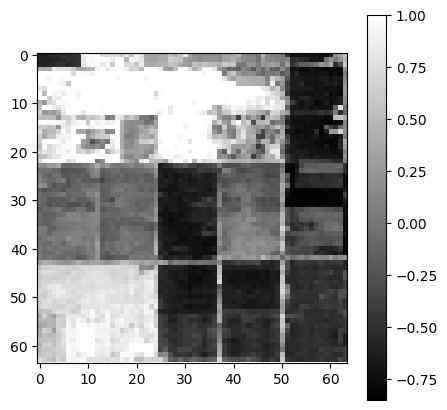

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(next(train_generator)[0],cmap='gray')
plt.colorbar()

### Testing Model

In [ ]:

def test_model(data_generator):
    img1,img2=next(data_generator)[:2]
    noise_var=np.random.rand()*.25
    # noise_var=.3
    noisy_img1=random_noise(img1,mode='speckle',var=noise_var,clip=True)
    noisy_img2=random_noise(img2,mode='speckle',var=noise_var,clip=True)
    noisy_img1=np.expand_dims(noisy_img1,axis=[0,-1])
    noisy_img2=np.expand_dims(noisy_img2,axis=[0,-1])
    denoised_img1=model.predict(noisy_img1)
    denoised_img2=model.predict(noisy_img2)
    fig,ax=plt.subplots(3,2,figsize=(10,12))
    mapple=ax[0,0].imshow(img1)
    plt.colorbar(mapple,ax=ax[0,0])
    mapple=ax[0,1].imshow(img2)
    plt.colorbar(mapple,ax=ax[0,1])
    mapple=ax[1,0].imshow(noisy_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,0])
    mapple=ax[1,1].imshow(noisy_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[1,1])
    mapple=ax[2,0].imshow(denoised_img1[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,0])
    mapple=ax[2,1].imshow(denoised_img2[0].reshape(INPUT_SIZE))
    plt.colorbar(mapple,ax=ax[2,1])
    plt.show()

### Model Creation

In [ ]:
def create_model(input_shape=(256,256,1)):
    input_layer=Input(shape=input_shape)
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same')(input_layer)
    x=LeakyReLU(.2)(x)
    for i in range(1,5):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same',)(x)
        x=BatchNormalization()(x)
        x=LeakyReLU(.2)(x)
    for i in range(4,0,-1):
        x=Conv2D(filters=64,kernel_size=(3,3),dilation_rate=i,padding='same')(x)
        x=BatchNormalization()(x)
        x=ReLU()(x)
    x=Conv2D(filters=1,kernel_size=(3,3),padding='same')(x)
    x=ReLU()(x)
    x= tf.keras.layers.Lambda(lambda x:x+tf.constant(1e-7))(x)
    x=tf.math.divide(input_layer,x)

    x=tf.math.tanh(x)
    return tf.keras.Model(inputs=input_layer,outputs=x)


### The loss function
- using MeanSquaredError and total_variation to implement the loss function

In [ ]:
MSE=tf.keras.losses.MeanSquaredError(reduction='none')
def loss_fn(y_true,y_pred,l_tv=.0002):
    mse=tf.reduce_sum(MSE(y_true,y_pred))
    variational_loss=tf.image.total_variation(y_pred)
    weight_loss = tf.reduce_sum(tf.math.abs(tf.math.divide(1,y_pred+1e-5)))
    total_loss=mse+l_tv*variational_loss
    return tf.reduce_mean(total_loss),tf.reduce_mean(mse),tf.reduce_mean(variational_loss)


### Training

In [ ]:
@tf.function
def step(noisy_data, clean_data):
    with tf.GradientTape() as tape:
        pred = model(noisy_data,training=True)
        total_loss,loss_euclidian,loss_tv = loss_fn(clean_data, pred)
        loss=tf.add_n([total_loss],model.losses)
    grads = tape.gradient(total_loss, model.trainable_weights)
    opt.apply_gradients(zip(grads, model.trainable_weights))
    return loss,loss_euclidian,loss_tv

In [ ]:
model=create_model(list(INPUT_SIZE)+[1])

1/1 [==============================] - 0s 29ms/step


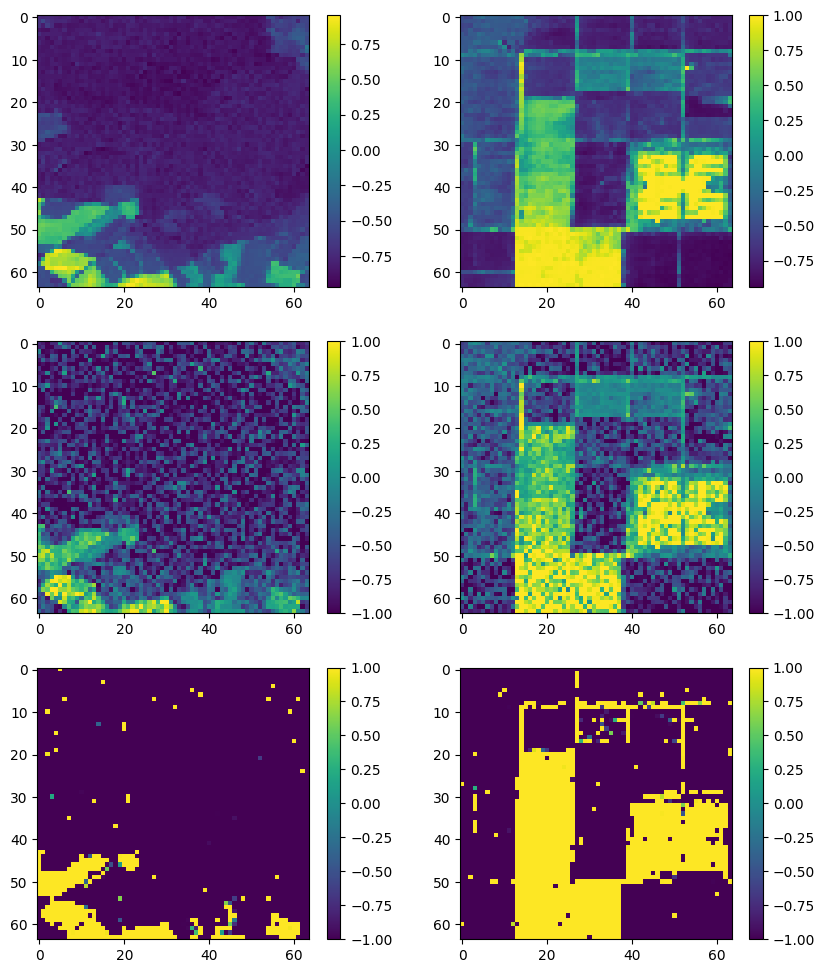

In [ ]:
test_model(train_generator)

[INFO] starting epoch 1/100 , learning_rate 0.002

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  1698.817138671875 loss_euclidian:  1698.5079345703125 loss_tv:  1549.0068359375


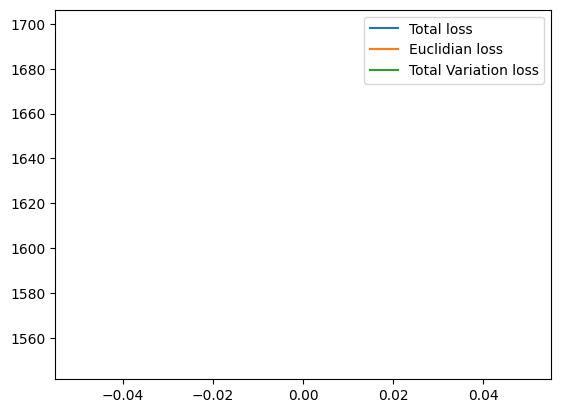

1/1 [==============================] - 0s 22ms/step


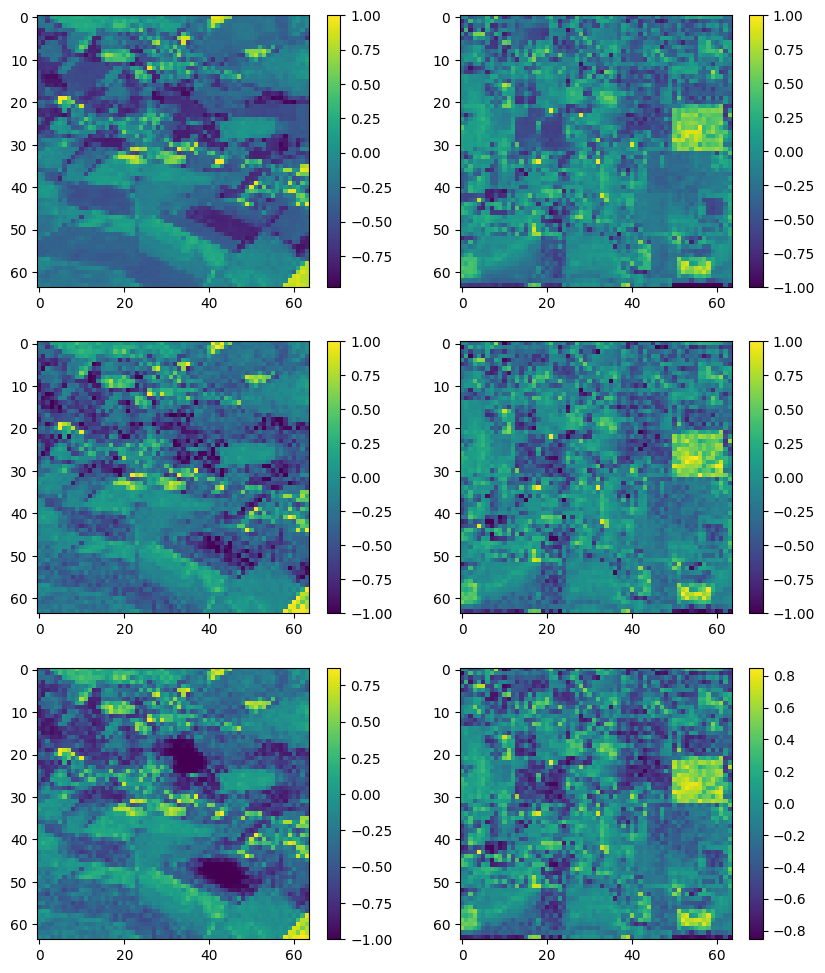

took 0.8722 minutes
[INFO] starting epoch 2/100 , learning_rate 0.002

  0%|          | 0/250 [00:00<?, ?it/s]


Training_loss #  total loss:  1437.5048828125 loss_euclidian:  1437.22705078125 loss_tv:  1387.5552978515625
took 0.5585 minutes
[INFO] starting epoch 3/100 , learning_rate 0.002

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
EPOCHS = 100
lr=2e-3

max_var=.3

opt = tf.keras.optimizers.Nadam(learning_rate=lr)
train_loss=[]
n_instances=train_generator.n
numUpdates = int(n_instances / BS)
# loop over the number of epochs
for epoch in range(0, EPOCHS):
    # show the current epoch number
    print("[INFO] starting epoch {}/{} , learning_rate {}".format(
        epoch + 1, EPOCHS,lr), end="")
    sys.stdout.flush()
    epochStart = time.time()
    loss = 0
    loss_batch = []
    for i in tqdm(range(0, numUpdates)):
        clean_data = next(train_generator)
        noisy_data=random_noise(clean_data,mode='speckle',var=np.random.uniform(high=max_var))
        loss = step(noisy_data,clean_data)
        loss_batch.append((loss))
    loss_batch = np.array(loss_batch)
    loss_batch = np.sum(loss_batch, axis=0) / len(loss_batch)
    total_loss,loss_euclidian,loss_tv=loss_batch
    train_loss.append(loss_batch)
    print('\nTraining_loss # ', 'total loss: ', float(total_loss),
          'loss_euclidian: ', float(loss_euclidian),
          'loss_tv: ', float(loss_tv),)
    if epoch % 5==0:
        plt.plot(train_loss)
        plt.legend(['Total loss','Euclidian loss','Total Variation loss'])
        plt.show()
        test_model(train_generator)
    sys.stdout.flush()
    # show timing information for the epoch
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("took {:.4} minutes".format(elapsed))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test_model(train_generator)